In [271]:
# passed on Python 3.10.7 @ Windows 11 and Python 3.10.6 @ MacOS Monterey

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [272]:
df = pd.read_csv('data1forEx1to4/train1_icu_data.csv')
mm = StandardScaler()
df = pd.DataFrame(mm.fit_transform(df), columns=df.columns)
df_label = pd.read_csv('data1forEx1to4/train1_icu_label.csv')
df['label'] = df_label['hospital_death']

## Fisher's Linear Discriminant (FLD)

In [273]:
cluster_1 = df[df['label'] == 1].values[:, :-1]
cluster_0 = df[df['label'] == 0].values[:, :-1]

In [274]:
m_1 = np.mean(cluster_1, axis=0).reshape(-1, 1)
m_0 = np.mean(cluster_0, axis=0).reshape(-1, 1)

In [275]:
S_w = np.zeros((df.shape[1] - 1, df.shape[1] - 1))
for i in range(cluster_1.shape[0]):
    S_w += (cluster_1[i].reshape(-1, 1) - m_1) @ (cluster_1[i].reshape(-1, 1) - m_1).T
for i in range(cluster_0.shape[0]):
    S_w += (cluster_0[i].reshape(-1, 1) - m_0) @ (cluster_0[i].reshape(-1, 1) - m_0).T

In [276]:
w = np.linalg.pinv(S_w) @ (m_1 - m_0)
w_0 = -0.5 * (w.T @ m_1 + w.T @ m_0)

In [277]:
def verify(x):
    return 1 if x > 0 else 0

result = np.vectorize(verify)(df.values[:, :-1] @ w + w_0[0][0])

In [278]:
check = result.reshape(1, -1)[0] == df['label'].values
check.sum() / check.shape[0]

0.7944

In [279]:
test_value = pd.read_csv('data1forEx1to4/test1_icu_data.csv')
test_value = pd.DataFrame(mm.transform(test_value), columns=test_value.columns).values

test_label = pd.read_csv('data1forEx1to4/test1_icu_label.csv').values
test_result = np.vectorize(verify)(test_value @ w + w_0[0][0])

test_check = test_result.reshape(1, -1)[0] == test_label.reshape(1, -1)[0]
test_check.sum() / test_check.shape[0]

0.7757520510483136

## Perceptron via `scikit-learn`

In [280]:
from sklearn.linear_model import Perceptron

clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(df.values[:, :-1], df['label'].values)
train_score = clf.score(df.values[:, :-1], df['label'].values)

test_value = pd.read_csv('data1forEx1to4/test1_icu_data.csv')
test_value = pd.DataFrame(mm.transform(test_value), columns=test_value.columns).values

test_label = pd.read_csv('data1forEx1to4/test1_icu_label.csv').values
test_score = clf.score(test_value, test_label)

print('Train score: {:.3f}, Test score: {:.3f}'.format(train_score, test_score))

Train score: 0.691, Test score: 0.656


In [281]:
df = pd.read_csv('data1forEx1to4/train2_icu_data.csv')
mm = StandardScaler()
df = pd.DataFrame(mm.fit_transform(df), columns=df.columns)
df_label = pd.read_csv('data1forEx1to4/train2_icu_label.csv')
df['label'] = df_label['hospital_death']

clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(df.values[:, :-1], df['label'].values)
train_score = clf.score(df.values[:, :-1], df['label'].values)

test_value = pd.read_csv('data1forEx1to4/test2_icu_data.csv')
test_value = pd.DataFrame(mm.transform(test_value), columns=test_value.columns).values

test_label = pd.read_csv('data1forEx1to4/test2_icu_label.csv').values
test_score = clf.score(test_value, test_label)

print('Train score: {:.3f}, Test score: {:.3f}'.format(train_score, test_score))

Train score: 1.000, Test score: 0.831


In [282]:
# cross validation
from sklearn.model_selection import cross_val_score
cross_val_score(clf, df.values[:, :-1], df['label'].values, cv=10)

array([0.98648649, 1.        , 0.97972973, 0.98648649, 0.98648649,
       0.98639456, 0.98639456, 0.96598639, 0.98639456, 0.99319728])

## Logistic Regression

In [283]:
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('data1forEx1to4/train1_icu_data.csv')
mm = StandardScaler()
df = pd.DataFrame(mm.fit_transform(df), columns=df.columns)
df_label = pd.read_csv('data1forEx1to4/train1_icu_label.csv')
df['label'] = df_label['hospital_death']

clf = LogisticRegression(random_state=0, max_iter=1000)
clf.fit(df.values[:, :-1], df['label'].values)
train_score = clf.score(df.values[:, :-1], df['label'].values)

test_value = pd.read_csv('data1forEx1to4/test1_icu_data.csv')
test_value = pd.DataFrame(mm.transform(test_value), columns=test_value.columns).values

test_label = pd.read_csv('data1forEx1to4/test1_icu_label.csv').values
test_score = clf.score(test_value, test_label)

print('Train score: {:.3f}, Test score: {:.3f}'.format(train_score, test_score))

Train score: 0.797, Test score: 0.788


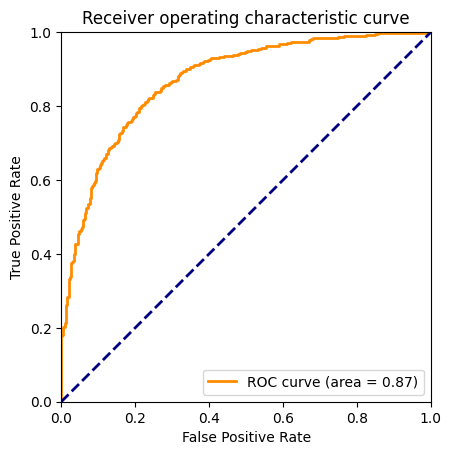

In [284]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(test_label, clf.predict_proba(test_value)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.axis('square')
lw = 2
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png', dpi=180)
plt.show()

In [314]:
a = [i for i in range(df.shape[1])]
col = a[:78] + a[79: 102] + a[103:(df.shape[1]-1)]

In [317]:
import statsmodels.api as sm

log_reg = sm.Logit(df['label'], df.iloc[:, col]).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.431350
         Iterations 18


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4904
Method:                           MLE   Df Model:                           95
Date:                Tue, 04 Oct 2022   Pseudo R-squ.:                  0.3775
Time:                        21:04:12   Log-Likelihood:                -2156.7
converged:                       True   LL-Null:                       -3464.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
age                                           0.4253      0.045      9.362      0.000       0.336       0.514
bmi                                           0.1906      0.214      0.889      0.374      -0.229       0.611
elective_surgery                             -0.2054      0.061     -3.389      0.001      -0.324      -0.087
height                                        0.0356      0.109      0.327      0.743      -0.177       0.249
pre_icu_los_days                              0.1668      0.044      3.831      0.000       0.081       0.252
weight                                       -0.2533      0.224     -1.129      0.259      -0.693       0.186
apache_2_diagnosis                            0.0835      0.052      1.605      0.109      -0.018       0.186
apache_3j_diagnosis                          -0.1024      0.076     -1.348      0.178      -0.251       0.047
arf_apache                                    0.0711      0.046      1.540      0.123      -0.019       0.162
bun_apache                                    0.2840      0.059      4.773      0.000       0.167       0.401
creatinine_apache                             0.0348      0.065      0.536      0.592      -0.092       0.162
gcs_eyes_apache                              -0.0966      0.084     -1.150      0.250      -0.261       0.068
gcs_motor_apache                             -0.2619      0.080     -3.272      0.001      -0.419      -0.105
gcs_verbal_apache                            -0.1336      0.069     -1.942      0.052      -0.268       0.001
glucose_apache                               -0.0729      0.055     -1.334      0.182      -0.180       0.034
heart_rate_apache                             0.0264      0.074      0.356      0.722      -0.119       0.172
hematocrit_apache                             0.2296      0.080      2.861      0.004       0.072       0.387
intubated_apache                              0.0398      0.050      0.790      0.430      -0.059       0.138
map_apache                                    0.0747      0.049      1.535      0.125      -0.021       0.170
resprate_apache                               0.0765      0.055      1.392      0.164      -0.031       0.184
sodium_apache                                -0.2244      0.092     -2.443      0.015      -0.404      -0.044
temp_apache                                   0.0094      0.081      0.117      0.907      -0.148       0.167
ventilated_apache                             0.4099      0.054      7.636      0.000       0.305       0.515
wbc_apache                                    0.2448      0.046      5.303      0.000       0.154       0.335
d1_diasbp_max                                 0.0604      0.088      0.685      0.493      -0.112       0.233
d1_diasbp_min                                 0.0203      0.094      0.216      0.829      -0.164       0.205
d1_heartrate_max                              0.332

In [332]:
logit_df = log_reg.summary().tables[1].data
logit_df = pd.DataFrame(logit_df[1:], columns=logit_df[0])
logit_df['P>|z|'] = logit_df['P>|z|'].astype(float)
logit_df[logit_df['P>|z|'] < 0.01]

,,coef,std err,z,P>|z|,[0.025,0.975]
0,age,0.4253,0.045,9.362,0.000,0.336,0.514
2,elective_surgery,-0.2054,0.061,-3.389,0.001,-0.324,-0.087
4,pre_icu_los_days,0.1668,0.044,3.831,0.000,0.081,0.252
9,bun_apache,0.2840,0.059,4.773,0.000,0.167,0.401
12,gcs_motor_apache,-0.2619,0.080,-3.272,0.001,-0.419,-0.105
16,hematocrit_apache,0.2296,0.080,2.861,0.004,0.072,0.387
22,ventilated_apache,0.4099,0.054,7.636,0.000,0.305,0.515
23,wbc_apache,0.2448,0.046,5.303,0.000,0.154,0.335
26,d1_heartrate_max,0.3320,0.083,3.987,0.000,0.169,0.495
33,d1_spo2_min,-0.3233,0.059,-5.440,0.000,-0.440,-0.207
